#### The Mortgage dataset reports information about 5960 home equity loans, which contains loans with a status indicator: defaulted(bad) or non-defaulted. Here is a short description of the data columns:
##### BAD: '1' = applicant defaulted on loan or seriously delinquent; 0 = applicant paid loan.
##### MORTDUE: Amount due on existing mortgage.
##### VALUE: Value of current property.
##### JOB: Occupational categories.
##### YOJ: Years at present job.
##### DEROG: Number of major derogatory reports.
##### DELINQ: Number of delinquent credit lines.
##### CLAGE: Age of oldest credit line in months.
##### NINQ: Number of recent credit enquiries.
##### CLNO: Number of credit lines.
##### DEBTINC: Debt-to-income ratio.

##### Goal: Calculate the RWA (risk-weighted assets) and capital requirements for the bank's portfolio in accordance with Basel III, using both the standardised approach (SA) and internal ratings-based approach (IRB).

Data loading and cleaning

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
from scipy.stats import norm
import statsmodels.api as sm
from typing import Dict

In [191]:
file_path = r"C:\Users\Beata\Downloads\Mortgage_default - hmeq.csv"
ra = pd.read_csv(file_path, sep=',')  
ra

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [192]:
print(ra.isnull().sum())

BAD           0
MORTDUE     518
VALUE       112
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64


In [193]:
print(ra.dtypes)

BAD          int64
MORTDUE    float64
VALUE      float64
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object


In [194]:
# Fill numeric columns with median
ra.fillna({col: ra[col].median() for col in ['MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'CLNO', 'DEBTINC']}, inplace=True)

# Fill numeric columns with 0
ra.fillna({col: 0 for col in ['DEROG', 'DELINQ', 'NINQ']}, inplace=True)

# Fill JOB with 'Unknown'
ra['JOB'] = ra['JOB'].fillna('Unknown')

In [195]:
# Splitting the data into predictors (X) and target variable (y)
X = ra[['MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'CLNO', 'DEBTINC', 'JOB', 'NINQ']]
y = ra['BAD']

In [196]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

In [197]:
# Fill numeric columns with median
X_train.fillna({col: X_train[col].median() for col in ['MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'CLNO', 'DEBTINC']}, inplace=True)

# Fill numeric columns with 0
X_train.fillna({col: 0 for col in ['DEROG', 'DELINQ', 'NINQ']}, inplace=True)

# Fill JOB with 'Unknown'
X_train['JOB'] = X_train['JOB'].fillna('Unknown')


In [205]:
# Fill numeric columns with median
X_test.fillna({col: X_test[col].median() for col in ['MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'CLNO', 'DEBTINC']}, inplace=True)

# Fill numeric columns with 0
X_test.fillna({col: 0 for col in ['DEROG', 'DELINQ', 'NINQ']}, inplace=True)

# Fill JOB with 'Unknown'
X_test['JOB'] = X_test['JOB'].fillna('Unknown')

In [207]:
print(X_train.isnull().sum())

MORTDUE    0
VALUE      0
YOJ        0
CLAGE      0
CLNO       0
DEBTINC    0
JOB        0
NINQ       0
dtype: int64


In [208]:
X_train.describe().round(2)

,MORTDUE,VALUE,YOJ,CLAGE,CLNO,DEBTINC,NINQ
count,4768.00,4768.00,4768.00,4768.00,4768.00,4768.00,4768.00
mean,73610.76,102180.08,8.90,180.02,21.33,33.97,1.07
std,43018.43,58049.37,7.29,82.61,9.97,7.39,1.65
min,2063.00,11550.00,0.00,0.00,0.00,0.72,0.00
25%,48264.25,66543.50,3.00,117.84,15.00,30.88,0.00
50%,65019.00,89235.50,7.00,173.47,20.00,34.82,0.00
75%,89236.75,120000.00,12.15,227.27,26.00,37.87,2.00
max,399550.00,855909.00,41.00,1168.23,71.00,203.31,17.00


### Exploratory Data Analysis

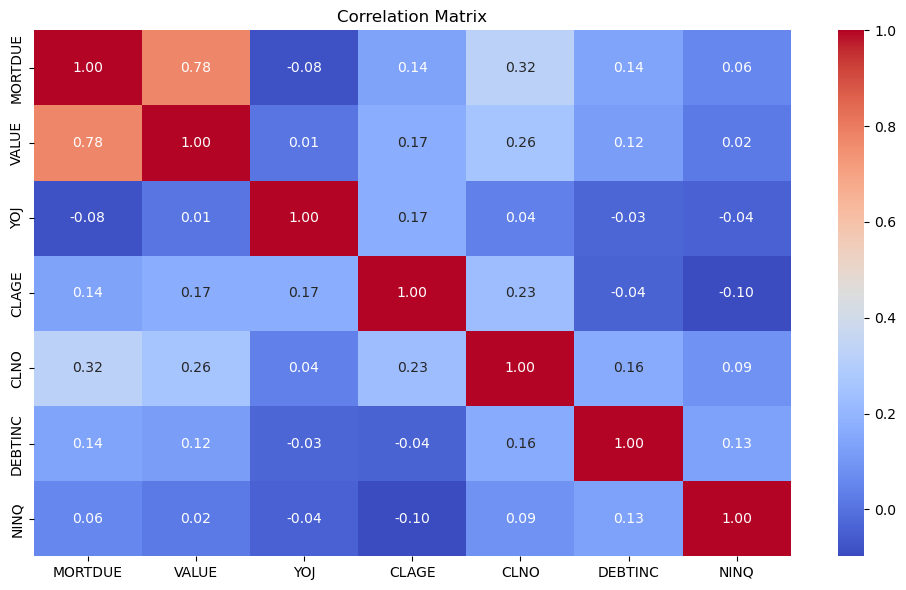

In [210]:
cv_corr = X_train.drop(columns=['JOB'])

correlation_matrix = cv_corr.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Strong Correlation: MORTDUE and VALUE: 0.79, larger mortgages are usually tied to more expensive properties.
Very Weak or No Correlation with BAD: MORTDUE, VALUE, YOJ, CLNO all have values near 0 → They’re not linearly correlated with default risk in dataset.

##### Boxplot for identifying outliers

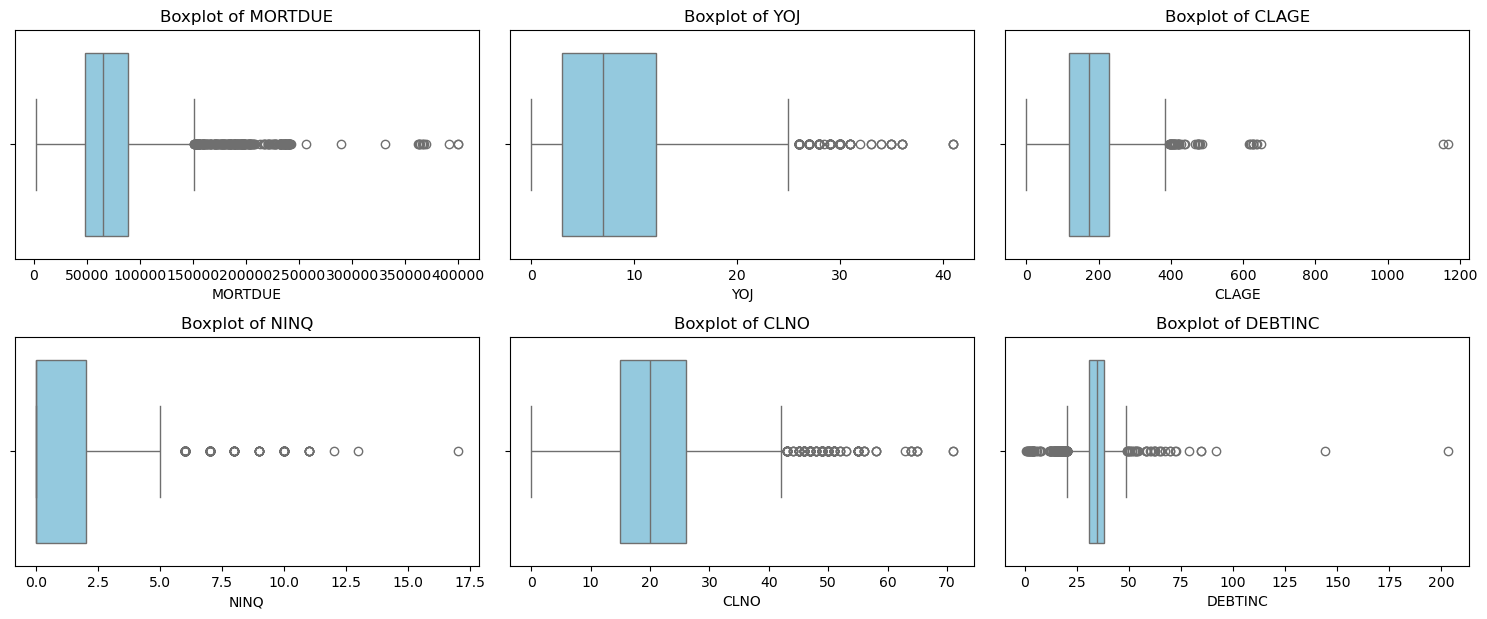

In [213]:
features = [
    'MORTDUE', 'YOJ',
     'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'
]

rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x=X_train[feature], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_xlabel(feature)

for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

MORTDUE Wide range, many high-value outliers (typical in mortgage debt). YOJ Years on job – strongly right-skewed: most people have short tenure. CLAGE Age of oldest credit line – higher values exist, but stable middle range. NINQ Recent credit inquiries – small integers, a few outliers ≥ 10. CLNO Number of credit lines – mostly between 10 and 40, with outliers > 50. DEBTINC Debt-to-income ratio – several extreme values, indicating risk 

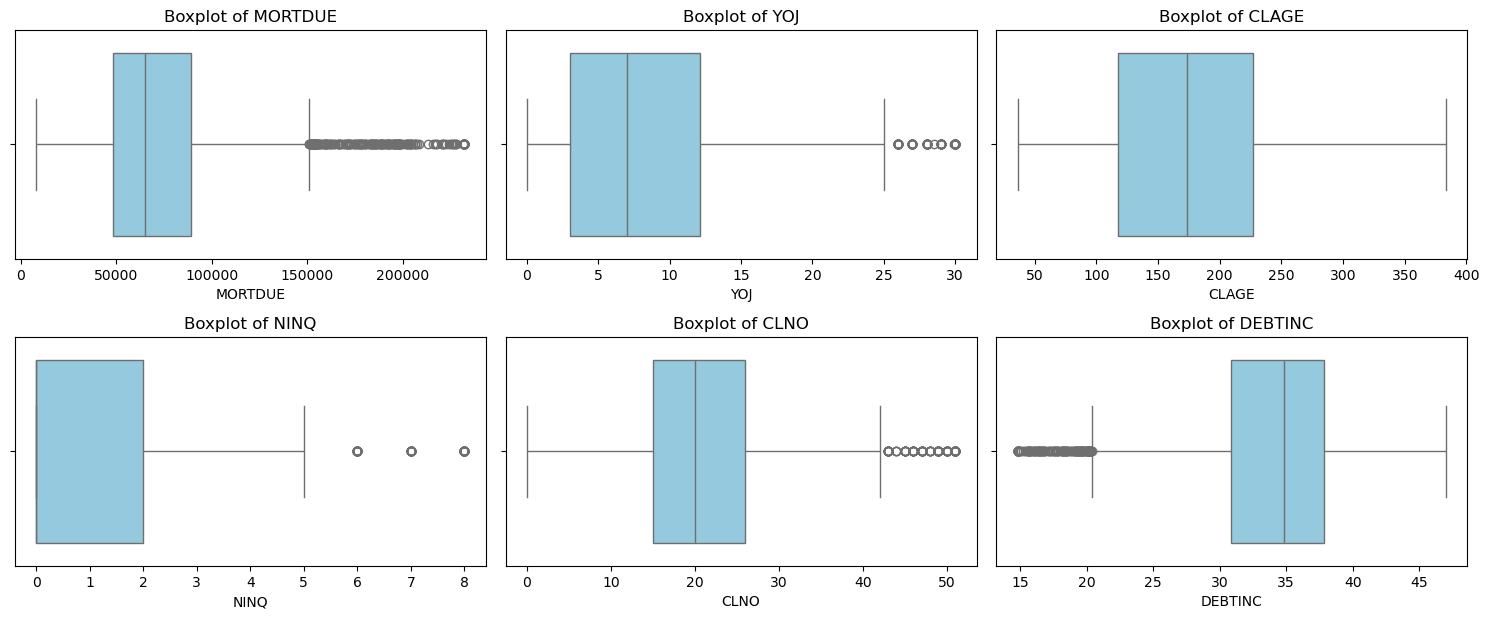

In [215]:
columns_to_cap = ['MORTDUE', 'YOJ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
 
for col in columns_to_cap:
    q_low = X_train[col].quantile(0.01)
    q_high = X_train[col].quantile(0.99)

    X_train[col] = X_train[col].clip(lower=q_low, upper=q_high)

    X_test[col] = X_test[col].clip(lower=q_low, upper=q_high)


rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(columns_to_cap):
    sns.boxplot(x=X_train[feature], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_xlabel(feature)

for j in range(len(columns_to_cap), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


MORTDUE Most extreme right-end outliers are now removed or trimmed. YOJ Long tail (over 30) is gone – values clipped at ~30. CLAGE Extreme old credit lines (>400 months) now capped to ~350. NINQ Very high credit inquiries (e.g. >8) no longer appear. CLNO Long right tail trimmed – max capped at ~50–60. DEBTINC No more extreme debt-to-income values (>100) – capped to ~45

### Modeling LogisticRregression

In [218]:
X_train = X_train.drop(columns=['JOB', 'VALUE'])
X_test = X_test.drop(columns=['JOB', 'VALUE'])

In [219]:
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, y_train) 

LogisticRegression(max_iter=10000)

In [220]:
# Computing predicted classes
train_class_preds = clf.predict(X_train)
test_class_preds = clf.predict(X_test)

In [221]:
# Get the predicted probabilities
y_proba_train = clf.predict_proba(X_train)[:, 1]
y_proba = clf.predict_proba(X_test)[:, 1]

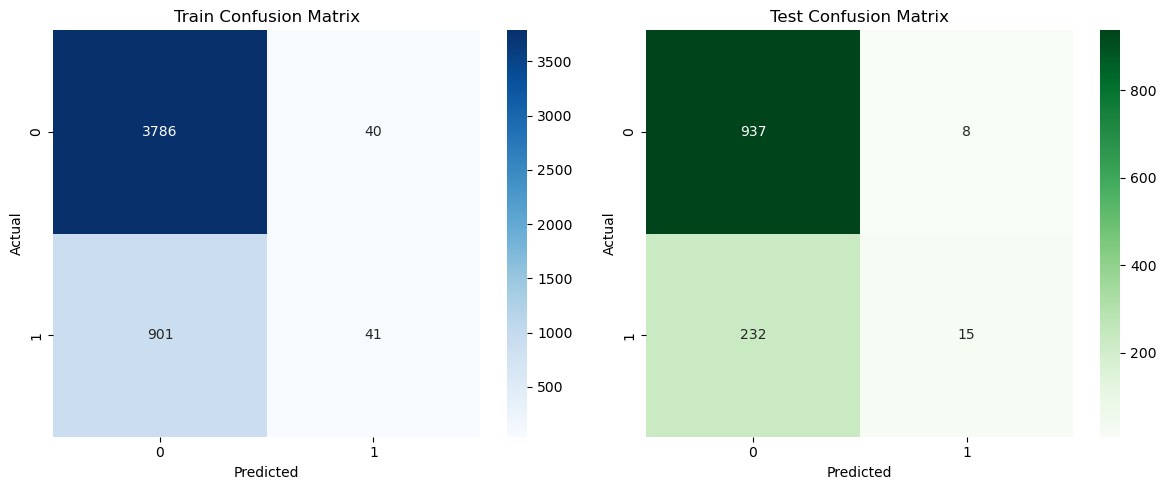

In [223]:
# Creating confusion matrices
cm_train = confusion_matrix(y_train, train_class_preds)
cm_test = confusion_matrix(y_test, test_class_preds)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Train Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Test Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

Train Confusion matrix: True Negatives 3786 non-defaults correctly predicted, False Positives 40 non-defaults incorrectly flagged as default,
False Negatives 901 defaults missed, True Positives 41 defaults correctly predicted.
Test Confusion matrix: True Negatives 937 non-defaults correctly predicted, False Positives 8 non-defaults incorrectly flagged as default,
False Negatives 232 defaults missed, It missed 232 defaulters, wrongly predicting them as safe. True Positives 15 defaults correctly predicted. The model correctly identified only 15 of them TP.
Model is very good at predicting people who non-default - 0.

In [310]:
# Generate predictions on testing set
y_pred = clf.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)

# Display classification report
print(report)

              precision    recall  f1-score   support

           0       0.80      0.99      0.89       945
           1       0.78      0.07      0.13       247

    accuracy                           0.80      1192
   macro avg       0.79      0.53      0.51      1192
weighted avg       0.80      0.80      0.73      1192



80% of total predictions are correct, mostly due to class 0. Class 0 is predicted very well. Macro avg: Precision, Recall, F1-score averaged equally over both classes. Weighted avg: Averages weighted by support (more weight to class 0)

In [227]:
roc_auc_score(y_test, y_proba)

0.7081742818584924

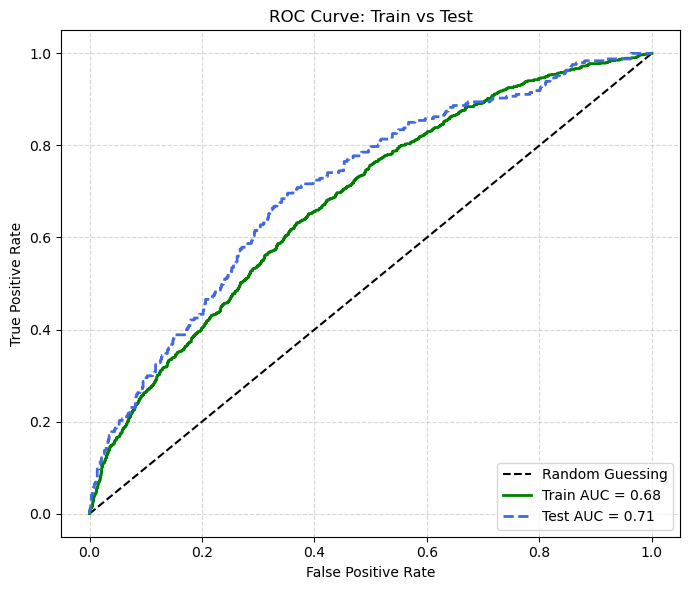

In [228]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
auc_train = roc_auc_score(y_train, y_proba_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_proba)
auc_test = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}',
         color='green', linestyle='-', linewidth=2)

plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}',
         color='royalblue', linestyle='--', linewidth=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Train vs Test')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The curve bows above the diagonal line, meaning the model is better than random guessing.
The test ROC (blue dashed) is slightly better than the train ROC (green), which could mean model is not overfitting a good sign.
Both AUCs ~0.7 Indicates a moderate discriminatory power. The model is better than chance, but not yet ideal. This is acceptable in many real-world credit risk models.

#### PD calculation using logistic regression model

In [245]:
# Splitting the data into predictors (X) and target variable (y)
X = ra[[ 'VALUE', 'YOJ', 'CLAGE', 'CLNO', 'DEBTINC', 'NINQ']]
y = ra['BAD']

In [249]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

In [251]:
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, y_train) 

LogisticRegression(max_iter=10000)

In [261]:
ra['PD'] = clf.predict_proba(X)[:, 1] 
ra

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,PD
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,0.262954
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,0.206284
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,0.222770
3,1,65019.0,89235.5,Unknown,7.0,0.0,0.0,173.466667,0.0,20.0,34.818262,0.166915
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,0.221742
...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0.139455
5956,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0.144764
5957,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0.140958
5958,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0.133300


In [328]:
percent_pd = ra['PD'].mean() * 100
print(f"Average PD: {percent_pd:.2f}%")

Average PD: 19.94%


#### Calculating credit risk RWA SA

In [263]:
# Filter non-default

ra['BAD'] = 0

ra['LTV'] = ra['MORTDUE'] / ra['VALUE']

# Fill missing LTV with default 0.45
ra['LTV'] = ra['LTV'].fillna(0.45)

# Recalculate LTV after filling missing values
ra['LTV'] = ra['MORTDUE'] / ra['VALUE']

ra['EAD'] = ra['MORTDUE']

#  RW assign_risk_weight
def calculate_rw(row):
    if row['BAD'] == 1:
        return 1.0  # 100%
    elif row['LTV'] > 1:
        return 0.7
    elif row['LTV'] > 0.9:
        return 0.5
    elif row['LTV'] > 0.8:
        return 0.4
    elif row['LTV'] > 0.6:
        return 0.3
    elif row['LTV'] > 0.5:
        return 0.25
    else:
        return 0.2

ra['RW'] = ra.apply(calculate_rw, axis=1)

# RWA = EAD × RW
ra['RWA'] = ra['EAD'] * ra['RW']
ra['Capital'] = ra['RWA'] * 0.08

ra

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,PD,LTV,EAD,RW,RWA,Capital
0,0,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,0.262954,0.662652,25860.0,0.30,7758.00,620.640
1,0,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,0.206284,1.024167,70053.0,0.70,49037.10,3922.968
2,0,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,0.222770,0.808383,13500.0,0.40,5400.00,432.000
3,0,65019.0,89235.5,Unknown,7.0,0.0,0.0,173.466667,0.0,20.0,34.818262,0.166915,0.728623,65019.0,0.30,19505.70,1560.456
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,0.221742,0.873214,97800.0,0.40,39120.00,3129.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0.139455,0.634961,57264.0,0.30,17179.20,1374.336
5956,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0.144764,0.587237,54576.0,0.25,13644.00,1091.520
5957,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0.140958,0.581604,54045.0,0.25,13511.25,1080.900
5958,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0.133300,0.548328,50370.0,0.25,12592.50,1007.400


#### Calculating credit risk RWA IRB

In [332]:
ra['LGD'] = 0.45

ra_nd = ra[ra['BAD'] == 0].copy()

ra_nd['R'] = 0.15

inv_PD = norm.ppf(ra_nd['PD'])
inv_999 = norm.ppf(0.999)

# Computing the Capital Requirement (K) for non-defaulted exposures using the Basel IRB formula.
# This is per unit of Exposure at Default (EAD).
ra_nd['K'] = ra_nd['LGD'] * (
    norm.cdf((inv_PD / np.sqrt(1 - ra_nd['R'])) +
             (np.sqrt(ra_nd['R']) / np.sqrt(1 - ra_nd['R'])) * inv_999) - ra['PD']
)

ra_nd['EL'] = ra_nd['PD'] * ra_nd['LGD'] * ra_nd['EAD']
ra_nd['RWA'] = ra_nd['K'] * 12.5 * ra_nd['EAD']
ra_nd['Capital'] = ra_nd['RWA'] * 0.08

ra_nd

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,PD,LTV,EAD,RW,RWA,Capital,LGD,EL,R,K
0,0,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,...,0.262954,0.662652,25860.0,0.30,67811.919484,5424.953559,0.45,3059.993226,0.15,0.209782
1,0,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,...,0.206284,1.024167,70053.0,0.70,178345.139750,14267.611180,0.45,6502.876251,0.15,0.203669
2,0,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,...,0.222770,0.808383,13500.0,0.40,34802.537452,2784.202996,0.45,1353.329132,0.15,0.206237
3,0,65019.0,89235.5,Unknown,7.0,0.0,0.0,173.466667,0.0,20.0,...,0.166915,0.728623,65019.0,0.30,157908.275320,12632.662026,0.45,4883.680658,0.15,0.194292
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,...,0.221742,0.873214,97800.0,0.40,251954.383770,20156.350702,0.45,9758.861312,0.15,0.206098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,...,0.139455,0.634961,57264.0,0.30,131993.933812,10559.514705,0.45,3593.582069,0.15,0.184401
5956,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,...,0.144764,0.587237,54576.0,0.25,127275.959736,10182.076779,0.45,3555.289665,0.15,0.186567
5957,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,...,0.140958,0.581604,54045.0,0.25,124997.449742,9999.795979,0.45,3428.129040,0.15,0.185027
5958,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,...,0.133300,0.548328,50370.0,0.25,114415.537556,9153.243004,0.45,3021.433225,0.15,0.181720


### Summary of results

In [326]:
summary_std = ra[['RWA']].sum().round(2)
summary_irb = ra_nd[['RWA']].sum().round(2)
total_ra = ra[['EAD']].sum().round(2)
total_nd = ra_nd[['EAD']].sum().round(2)

CET1_req_SA = summary_std['RWA'] * 0.045
tier1_req_SA = summary_std['RWA'] * 0.06
total_capital_req_SA = summary_std['RWA'] * 0.08

CET1_req_IRB = summary_irb['RWA'] * 0.045
tier1_req_IRB = summary_irb['RWA'] * 0.06
total_capital_req_IRB = summary_irb['RWA'] * 0.08

comparison = pd.DataFrame({
    'Standardized': [
        summary_std['RWA'],
        total_ra['EAD'],
        CET1_req_SA,
        tier1_req_SA,
        total_capital_req_SA
    ],
    'IRB': [
        summary_irb['RWA'],
        total_nd['EAD'],
        CET1_req_IRB,
        tier1_req_IRB,
        total_capital_req_IRB
    ]
}, index=[
    'Total RWA',
    'Total EAD',
    'CET1 Requirement (4.5%)',
    'Tier 1 Requirement (6%)',
    'Total Capital Requirement (8%)'
])

comparison = comparison.map(lambda x: f"{x:,.2f}")

display(comparison)


,Standardized,IRB
Total RWA,"152,256,069.83","1,018,454,067.16"
Total EAD,"435,086,209.20","435,086,209.20"
CET1 Requirement (4.5%),"6,851,523.14","45,830,433.02"
Tier 1 Requirement (6%),"9,135,364.19","61,107,244.03"
Total Capital Requirement (8%),"12,180,485.59","81,476,325.37"


The IRB approach results in significantly higher RWAs and capital requirements compared to the Standardized approach. RB approach is heavily influenced by the internally estimated Probability of Default (PD). For this portfolio, the PD is around 20%, which is relatively high—implying that one in five borrowers is expected to default. Such a high PD significantly increases the capital requirement (k) and, consequently, the total RWA. If PD or LGD were reduced, the RWA under the IRB approach would likely have been much closer to the SA figures.